In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()
index = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})
index

,ticker,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
rolling_window = 10
market.connect()
prices = []
skips = 1
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            dividends = market.query("dividends",{"ticker":ticker})
            if dividends.index.size > 0:
                dividends = p.utc_date(dividends)
                price = price.merge(dividends,on=["date","ticker"])
                price["dividend"] = price["rate"].ffill().fillna(0)
            else:
                price["dividend"] = 0
            price = Metric.DISTANCE.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Indicator.EMACorr.calculate(price,timeframe=rolling_window)
            price = RiskType.COEFFICIENT_OF_VARIATION.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:14<00:00, 35.10it/s]


In [8]:
model_end = 2020
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [9]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                "ema_corr"
                                                            ]
                                                            ,num_of_groups=[3]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[3]
                                                            ,min_prices=[1]
                                                            ,stoplosses=[0.05]
                                                            ,rolling_windows=[rolling_window]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "day"  and "top_blacklist" in portfolio.selection_type.label  and portfolio.allocation_type.label == "risk" \
            and portfolio.position_type.label == "long" and "distance" in portfolio.grouping_type.value   and portfolio.max_price > portfolio.min_price:
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

1

In [10]:
analysises = []
portfolio_value = 10
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


In [11]:
a = pd.DataFrame(analysises)

In [12]:
metric = "raw_pnl"
dropped_columns = ["date","risk_type","timeframe","selection_percentage","stoploss","position_type","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,grouping_type,selection_type,allocation_type,num_of_groups,max_price,min_price,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio
0,ema_corr,DISTANCE,top_blacklist,risk,3,3,1,2.069251,2.284307,0.95,5.334281,0.387916,2.968756,0.407912,2.823221


In [13]:
# orivault.cloud_connect()
# orivault.drop("results")
# orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
# orivault.disconnect()

In [14]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

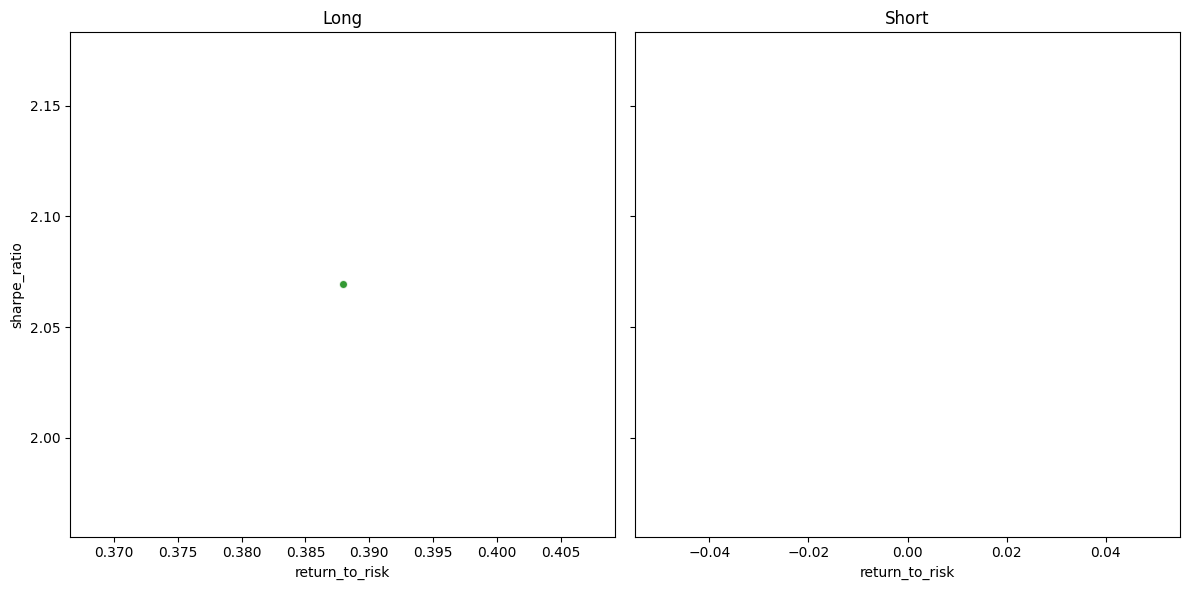

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [16]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

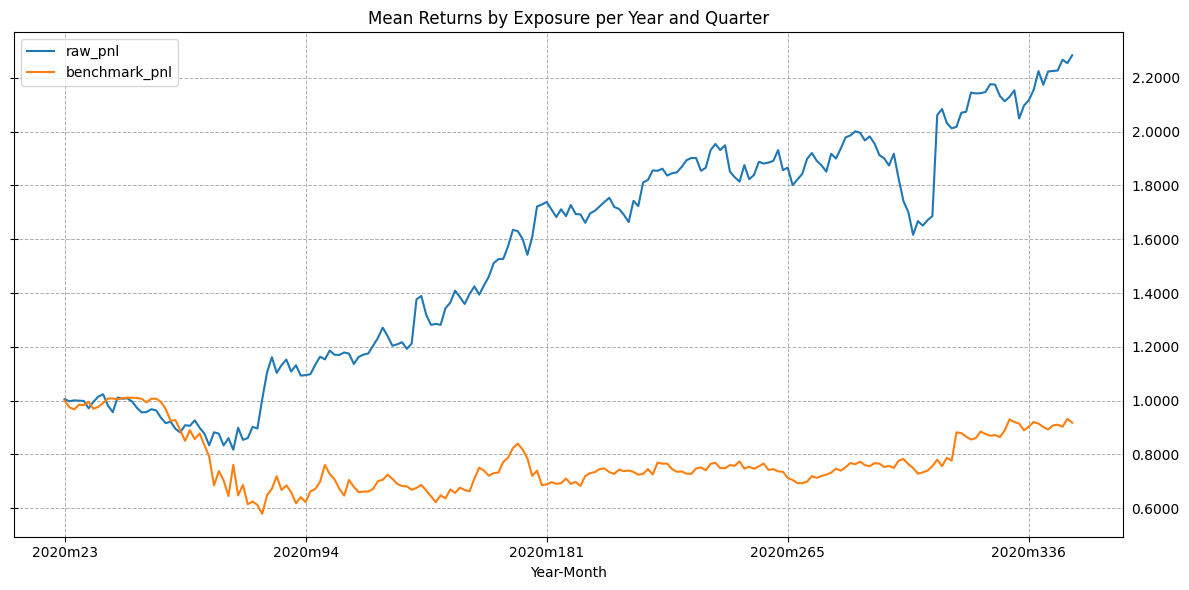

In [17]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
SMCI,0.003882


In [19]:
portfolio.sort_values("date")

,index,year,day,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,month,quarter,week,Year-Month
0,0,2020,23,2020-01-23 00:00:00+00:00,1.005210,1.005210,1.005210,1.005210,117.51,1.000000,1,1,4,2020m23
1,1,2020,24,2020-01-24 00:00:00+00:00,0.992053,0.992053,0.997221,0.997221,114.59,0.975151,1,1,4,2020m24
2,2,2020,27,2020-01-27 00:00:00+00:00,1.003483,1.003483,1.000695,1.000695,113.63,0.966982,1,1,5,2020m27
3,3,2020,28,2020-01-28 00:00:00+00:00,0.998959,0.998959,0.999653,0.999653,115.70,0.984597,1,1,5,2020m28
4,4,2020,29,2020-01-29 00:00:00+00:00,0.998958,0.998958,0.998611,0.998611,115.52,0.983065,1,1,5,2020m29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,205,2020,350,2020-12-15 00:00:00+00:00,1.001003,1.001003,2.016444,2.226011,106.64,0.907497,12,4,51,2020m350
206,206,2020,351,2020-12-16 00:00:00+00:00,1.000668,1.000668,2.017791,2.227499,106.95,0.910135,12,4,51,2020m351
207,207,2020,352,2020-12-17 00:00:00+00:00,1.018030,1.018030,2.054172,2.267661,106.06,0.902561,12,4,51,2020m352
208,208,2020,356,2020-12-21 00:00:00+00:00,0.994328,0.994328,2.042520,2.254798,109.50,0.931836,12,4,52,2020m356


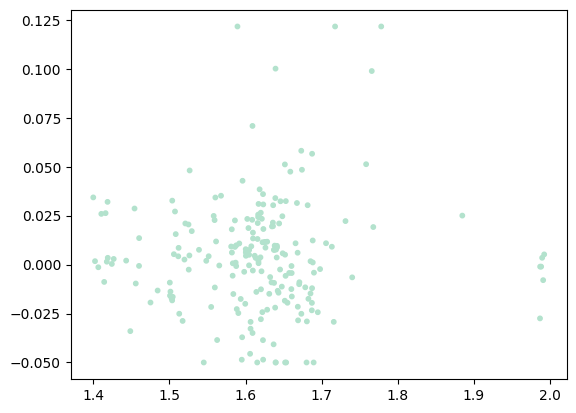

In [20]:
plt.scatter(trades["distance"],trades["return"],s=10,c=trades["group_percentile"].astype(int)*10,cmap="Pastel2")
plt.show()

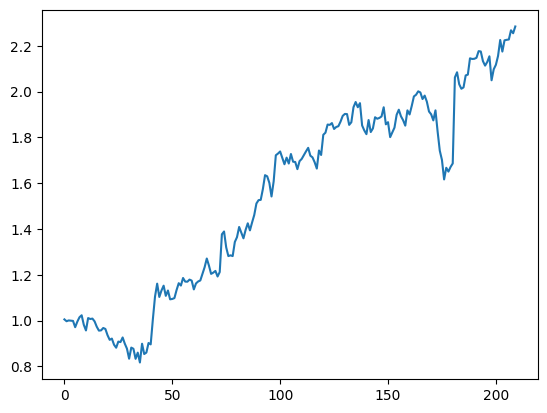

In [21]:
averaged_portfolio = portfolio.groupby("day").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["weighted_return"].cumprod()
plt.plot(averaged_portfolio["pv"])
plt.show()

In [22]:
trades.tail(20)

,year,day,ticker,date,adjclose,sell_price,distance,ema_corr,risk,group_percentile,...,position_type,weight,unweighted_return,stoploss_return,winsorized_return,weighted_return,return,month,quarter,week
190,2020,72,SMCI,2020-03-12 00:00:00+00:00,2.220,2.292,1.652904,-0.003157,0.064576,2,...,1.0,1.0,1.032432,1.032432,1.032432,0.032432,0.032432,3,1,11
191,2020,73,SMCI,2020-03-13 00:00:00+00:00,2.292,1.738,1.639399,0.020694,0.066446,2,...,1.0,1.0,0.758290,0.950000,0.950000,-0.050000,-0.050000,3,1,11
192,2020,76,SMCI,2020-03-16 00:00:00+00:00,1.738,1.912,1.639376,0.036500,0.098034,2,...,1.0,1.0,1.100115,1.100115,1.100115,0.100115,0.100115,3,1,12
193,2020,77,SMCI,2020-03-17 00:00:00+00:00,1.912,1.598,1.615319,-0.105576,0.111607,2,...,1.0,1.0,0.835774,0.950000,0.950000,-0.050000,-0.050000,3,1,12
194,2020,78,SMCI,2020-03-18 00:00:00+00:00,1.598,1.610,1.637239,-0.039558,0.137369,2,...,1.0,1.0,1.007509,1.007509,1.007509,0.007509,0.007509,3,1,12
195,2020,79,SMCI,2020-03-19 00:00:00+00:00,1.610,1.688,1.674081,-0.036459,0.155789,2,...,1.0,1.0,1.048447,1.048447,1.048447,0.048447,0.048447,3,1,12
196,2020,80,SMCI,2020-03-20 00:00:00+00:00,1.688,1.677,1.740083,-0.100717,0.166794,2,...,1.0,1.0,0.993483,0.993483,0.993483,-0.006517,-0.006517,3,1,12
197,2020,83,SMCI,2020-03-23 00:00:00+00:00,1.677,1.881,1.778221,-0.056097,0.176851,2,...,1.0,1.0,1.121646,1.121646,1.121646,0.121646,0.121646,3,1,13
198,2020,84,SMCI,2020-03-24 00:00:00+00:00,1.881,2.067,1.765790,-0.296412,0.179301,2,...,1.0,1.0,1.098884,1.098884,1.098884,0.098884,0.098884,3,1,13
199,2020,85,SMCI,2020-03-25 00:00:00+00:00,2.067,2.173,1.758373,-0.152470,0.176455,2,...,1.0,1.0,1.051282,1.051282,1.051282,0.051282,0.051282,3,1,13
